In [1]:
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
import numpy as np
import scipy.sparse as sparse
import contextily as cx
from shapely.geometry import Polygon
import descartes

In [2]:
data = geopandas.read_file("metro-data.geojson")
dataf = geopandas.GeoDataFrame(data)
print(dataf.head(5))

   OBJECTID_1  OBJECTID TIS_ID HMGNS_FLOW  HMGNS_LNK_  \
0           6       704  14009      14009        7954   
1           8       706  12967      12967        7398   
2          10       708   9606       9606        3016   
3          14       712  11314      11314        5873   
4          16       727  11860      11860        5719   

                                          HMGNS_LN_1 LGA_SHORT_  \
0  GREEN GULLY ROAD btwn CALDER HIGHWAY Offramp &...   BRIMBANK   
1  BOUNDARY ROAD btwn PALMERS ROAD & MT DERRIMUT ...    WYNDHAM   
2  SHARPS ROAD btwn KEILOR PARK DRIVE & AIRPORT D...       HUME   
3           KINGS ROAD btwn TAYLORS ROAD & MAIN ROAD   BRIMBANK   
4        SOUTH ROAD btwn NEW STREET & HAMPTON STREET    BAYSIDE   

                       RGN_LONG_N  ROAD_NBR            DECLARED_R  ...  \
0  METROPOLITAN NORTH WEST REGION      5875  KEILOR-LAVERTON ROAD  ...   
1  METROPOLITAN NORTH WEST REGION      9999        Not Applicable  ...   
2  METROPOLITAN NORTH WEST REGIO

In [3]:
sdf = dataf[['HMGNS_LNK_', 'geometry']]
sdf = sdf.to_crs(epsg=7899)
print(sdf)

      HMGNS_LNK_                                           geometry
0           7954  MULTILINESTRING ((2484862.454 2420520.217, 248...
1           7398  MULTILINESTRING ((2479683.364 2409842.125, 247...
2           3016  MULTILINESTRING ((2488311.682 2421550.895, 248...
3           5873  MULTILINESTRING ((2480554.438 2417641.850, 248...
4           5719  MULTILINESTRING ((2500354.176 2396859.436, 250...
...          ...                                                ...
5284        8124  MULTILINESTRING ((2503186.007 2403153.379, 250...
5285        7302  MULTILINESTRING ((2490520.299 2411336.916, 249...
5286        7319  MULTILINESTRING ((2499399.058 2399640.636, 249...
5287        1367  MULTILINESTRING ((2499093.732 2411870.985, 249...
5288        1367  MULTILINESTRING ((2499118.142 2411871.122, 249...

[5289 rows x 2 columns]


In [4]:
hourly = pd.read_csv('TYPICAL_HOURLY_VOLUME_DATA.csv')
hourly_dropped = hourly.drop(['HMGNS_FLOW_ID', 'HMGNS_LNK_DESC', 'FLOW', 'COUNT_TYPE', 'PERIOD_TYPE'], axis=1)
print(hourly_dropped.head())

   HMGNS_LNK_ID  DOW  0:00  1:00  2:00  3:00  4:00  5:00  6:00  7:00  ...  \
0          7581    1  1314   835   636   562   531   701  1416  2544  ...   
1          7581    1  1189   597   495   391   526  1173  3089  5196  ...   
2          7581    1   836   461   316   299   442  1080  2999  5226  ...   
3          7581    2  1344   742   483   423   414   722  2108  4219  ...   
4          7581    2  1178   620   421   359   422   902  2520  4594  ...   

   14:00  15:00  16:00  17:00  18:00  19:00  20:00  21:00  22:00  23:00  
0   5030   5891   6279   6708   5039   3358   2853   2496   2205   1804  
1   5874   7934   8342   8761   7501   4594   3063   2663   2347   1803  
2   5951   7453   7955   8152   6779   4002   2834   2569   2116   1415  
3   5360   6594   7558   8058   7209   4988   3619   3071   2671   2587  
4   5389   6880   7325   7902   6707   4305   3059   2744   2477   2048  

[5 rows x 26 columns]


In [5]:
hourly_dropped = hourly_dropped.rename(columns={"0:00": "0", "1:00": "1", "2:00": "2", "3:00": "3", "4:00": "4", "5:00": "5", "6:00": "6", "7:00": "7", "8:00": "8", "9:00": "9", "10:00": "10", "11:00": "11", "12:00": "12", "13:00": "13", "14:00": "14", "15:00": "15", "16:00": "16", "17:00": "17", "18:00": "18", "19:00": "19", "20:00": "20", "21:00": "21", "22:00": "22", "23:00": "23"}, errors="raise")
print(hourly_dropped.head())

   HMGNS_LNK_ID  DOW     0    1    2    3    4     5     6     7  ...    14  \
0          7581    1  1314  835  636  562  531   701  1416  2544  ...  5030   
1          7581    1  1189  597  495  391  526  1173  3089  5196  ...  5874   
2          7581    1   836  461  316  299  442  1080  2999  5226  ...  5951   
3          7581    2  1344  742  483  423  414   722  2108  4219  ...  5360   
4          7581    2  1178  620  421  359  422   902  2520  4594  ...  5389   

     15    16    17    18    19    20    21    22    23  
0  5891  6279  6708  5039  3358  2853  2496  2205  1804  
1  7934  8342  8761  7501  4594  3063  2663  2347  1803  
2  7453  7955  8152  6779  4002  2834  2569  2116  1415  
3  6594  7558  8058  7209  4988  3619  3071  2671  2587  
4  6880  7325  7902  6707  4305  3059  2744  2477  2048  

[5 rows x 26 columns]


In [6]:
hourly_long = hourly_dropped.melt(id_vars=['HMGNS_LNK_ID','DOW'], value_vars=hourly_dropped.iloc[:,2:27], var_name='Hour', value_name='Value')
hourly_long['Hour'] = pd.to_numeric(hourly_long['Hour'])
print(hourly_long.head(10))

   HMGNS_LNK_ID  DOW  Hour  Value
0          7581    1     0   1314
1          7581    1     0   1189
2          7581    1     0    836
3          7581    2     0   1344
4          7581    2     0   1178
5          7581    2     0    915
6          7581    3     0    854
7          7581    3     0   1140
8          7581    3     0    905
9          7581    4     0    882


In [7]:
grouped_hourly = hourly_long.groupby('DOW')
print(grouped_hourly.head(10))

    HMGNS_LNK_ID  DOW  Hour  Value
0           7581    1     0   1314
1           7581    1     0   1189
2           7581    1     0    836
3           7581    2     0   1344
4           7581    2     0   1178
..           ...  ...   ...    ...
69          8726    3     0    941
72          8726    4     0    972
75          8726    5     0   1255
78          8726    6     0   2228
81          8726    7     0   2694

[70 rows x 4 columns]


In [35]:
grouped_multiple = hourly_long.groupby(['DOW', 'HMGNS_LNK_ID', 'Hour']).agg({'Value': 'mean'})
grouped_multiple.columns = ['Average Value']
grouped_multiple = grouped_multiple.reset_index()
sorted_df = grouped_multiple.sort_values(["HMGNS_LNK_ID", "DOW", "Hour"], ascending = (True, True, True))
print(sorted_df.head(25))

        DOW  HMGNS_LNK_ID  Hour  Average Value
0         1             2     0     909.833333
1         1             2     1     531.166667
2         1             2     2     424.166667
3         1             2     3     422.666667
4         1             2     4     739.666667
5         1             2     5    2027.000000
6         1             2     6    4628.833333
7         1             2     7    5888.166667
8         1             2     8    6070.000000
9         1             2     9    5164.333333
10        1             2    10    4920.166667
11        1             2    11    5074.666667
12        1             2    12    5186.166667
13        1             2    13    5173.500000
14        1             2    14    5574.666667
15        1             2    15    6509.000000
16        1             2    16    6948.000000
17        1             2    17    7482.666667
18        1             2    18    6003.666667
19        1             2    19    3744.500000
20        1  

In [36]:
sorted_df['Normalised Value']=(sorted_df['Average Value']-sorted_df['Average Value'].min())/(sorted_df['Average Value'].max()-sorted_df['Average Value'].min())
sorted_df['Normalised Value']=3*sorted_df['Normalised Value']

In [40]:
df = sdf.merge(sorted_df, left_on="HMGNS_LNK_", right_on="HMGNS_LNK_ID", how="left")
print(df.head(30))

    HMGNS_LNK_                                           geometry  DOW  \
0         7954  MULTILINESTRING ((2484862.454 2420520.217, 248...  1.0   
1         7954  MULTILINESTRING ((2484862.454 2420520.217, 248...  1.0   
2         7954  MULTILINESTRING ((2484862.454 2420520.217, 248...  1.0   
3         7954  MULTILINESTRING ((2484862.454 2420520.217, 248...  1.0   
4         7954  MULTILINESTRING ((2484862.454 2420520.217, 248...  1.0   
5         7954  MULTILINESTRING ((2484862.454 2420520.217, 248...  1.0   
6         7954  MULTILINESTRING ((2484862.454 2420520.217, 248...  1.0   
7         7954  MULTILINESTRING ((2484862.454 2420520.217, 248...  1.0   
8         7954  MULTILINESTRING ((2484862.454 2420520.217, 248...  1.0   
9         7954  MULTILINESTRING ((2484862.454 2420520.217, 248...  1.0   
10        7954  MULTILINESTRING ((2484862.454 2420520.217, 248...  1.0   
11        7954  MULTILINESTRING ((2484862.454 2420520.217, 248...  1.0   
12        7954  MULTILINESTRING ((2484

In [38]:
smol_df = df.iloc[0:10000, :]

In [42]:
print(cx.providers.keys())
cx.providers.CartoDB.keys()


dict_keys(['OpenStreetMap', 'OpenSeaMap', 'OpenPtMap', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Thunderforest', 'OpenMapSurfer', 'Hydda', 'MapBox', 'Stamen', 'Esri', 'OpenWeatherMap', 'HERE', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'Wikimedia', 'GeoportailFrance', 'OneMapSG'])


dict_keys(['Positron', 'PositronNoLabels', 'PositronOnlyLabels', 'DarkMatter', 'DarkMatterNoLabels', 'DarkMatterOnlyLabels', 'Voyager', 'VoyagerNoLabels', 'VoyagerOnlyLabels', 'VoyagerLabelsUnder'])

<AxesSubplot:>

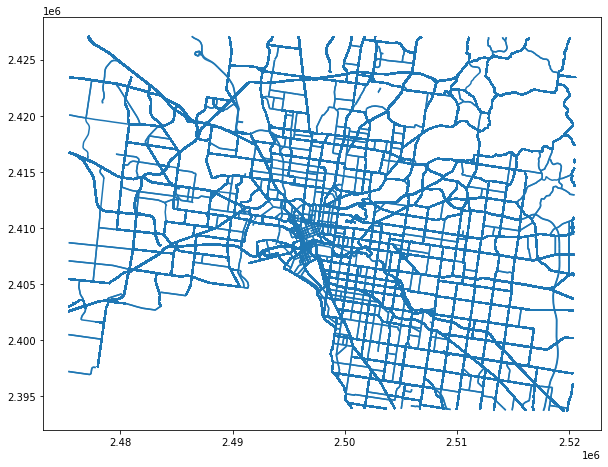

In [33]:
df.plot(figsize=(10, 10))

KeyboardInterrupt: 

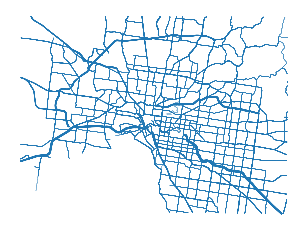

In [39]:
for dow in df['DOW']:
    fig, ax = plt.subplots(1)
    day_df = df[df['DOW']==dow]

    for hour in df['Hour']:
        day_hour_df = day_df[day_df['Hour']==hour]
        day_hour_df.plot(ax=ax, linewidth=day_hour_df['Normalised Value'])
        ax.axis('off')
        plt.savefig("day-{}_hour-{}.png".format(dow, hour), dpi = 500, facecolor='black')
        continue

In [22]:
print(df['DOW'].head(27))

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    2.0
25    2.0
26    2.0
Name: DOW, dtype: float64
